In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import torch
import pyro

# An introduction to Normalizing Flow models

Normalizing flows (NFs) are likelihood-based generative models, similar to VAE. The main difference is that the marginal likelihood $p(x)$ of VAE is not tractable, hence relying on the ELBO. On the other hand, NF has a tractable marginal likelihood, i.e. we can write a direct expression for $\max \log p(x)$

In a nutshell NF is a composition of "simple" transformations (hence the name flow) applied to a "simple" distribution, in order to obtain a more complex distribution. NF have been extensively used to [obtain more flexible approximate posteriors in VI](https://arxiv.org/pdf/1505.05770.pdf), i.e. to  go beyond the mean field approximation. 

In this lesson we review the fundamental concepts and simple implementations of NF 

## Change of variables formula

Let X and Z be **continuous** random variables **having the same dimensionality** and $f_\theta: \mathbb{R}^D \to \mathbb{R}^D$ a parametric mapping such that $x = f_\theta(z)$, where $x$ and $z$ are samples from $X$ and $Z$, respectively. 

We will assumme that the mapping is **invertible**, *i.e.* $z=f_\theta^{-1}(x)$

In this case we have the following relation between the distributions marginal distributions $p_X(x)$ and $p_Z(z)$

$$
\begin{align}
p_X(x) &= p_Z\left(f_\theta^{-1}(x)\right) \left| \text{det}\left( \frac{\partial f_\theta^{-1}}{\partial x} \right) \right| \nonumber \\
&= p_Z( z ) \left| \text{det}\left(\frac{\partial f_\theta}{\partial z} \right) \right|^{-1}
\end{align}
$$

where $|\cdot|$ is the absolute value and $\text{det}$ is the determinant operator. This is known as the [change of variables formula](https://en.wikipedia.org/wiki/Probability_density_function#Function_of_random_variables_and_change_of_variables_in_the_probability_density_function) for probability density functions. It comes from the fact that $\int p_X(x) dx = \int p_Z(z) dz = 1$

The determinant is only defined for square matrices. The matrix in this case is the jacobian of $f_\theta$, the matrix of partial derivatives. If the transformation is invertible the jacobian is an invertible matrix, hence $\text{det}(A^{-1}) = \text{det}(A)^{-1}$

## Planar and Radial flows

Several linear and nonlinear invertible transformations have been proposed. In what follows we review some of them starting from the so-called [planar flow](https://arxiv.org/pdf/1505.05770.pdf)

$$
x = f_\theta(z) = z + u h\left(\langle w, z \rangle + b\right)
$$

where $\theta = (u, w, b)$ and $h$ is a smooth element-wise non linear function. This transformations can be interpreted as a contraction/expansion of the distribution in the direction perpendicular to the hyperplane $\langle w, z \rangle + b$, hence the name planar flow. 

A typical non-linear function is $\tanh$, in this case $w^T u \geq -1$ is a sufficient condition for the invertibility of the transformation. This constraint is enforced by taking an arbitrary $u$ and making it parallel to $w$ using this vector instead (See the appendix [here](https://arxiv.org/pdf/1505.05770.pdf))

In general computing the determinant of a $D \times D$ has $\mathcal{O}(D)$ complexity, hence it is convenient to look for transformations where the determinant of the jacobian is easy to compute. For planar flows the jacobian is

$$
\text{det}\left(\frac{\partial f_\theta}{\partial z} \right) = 1 + u^T h'\left(\langle w, z \rangle + b\right) w
$$

which can be computed in $\mathcal{O}(D)$

Another family of transformations consider contraction/expansion of the distribution around a reference point $z_0$, these are the radial flows

$$
f_\theta(z) = z + \frac{\beta}{\alpha + r} (z-z_0)
$$

where $\theta=(z_0, \alpha, \beta)$ and $r =  |z-z_0|$. A sufficient condition for invertibility is that $\frac{r\beta}{\alpha + r}$ is non-decreasing, which can be forced by reparametrization of $\beta$ as $\hat \beta = - \alpha + \log(1+e^\beta)$

## Composition of finite flows

For three random variables having the same dimensionality and two invertible parametric mappings such that $z_3 = f_{\theta}(z_2)$ and  $z_2 = g_{\phi}(z_1)$ we can use the change of variables to relate $z_3 = f_\theta(g_\phi(z_1))$ also written as $z_3 = f_\theta \odot g_\phi (z_1)$ as

$$
p(z_3) = p(z_1) \left| \text{det}\left(\frac{\partial f_\theta}{\partial z_2} \right) \right|^{-1} \left| \text{det}\left(\frac{\partial g_\phi}{\partial z_1} \right) \right|^{-1}
$$

Different transformations can be used but it is more convenient to use one family and change only the parameters. We can generalize this to a finite composition of $K$ random variables $z_K = f_{\theta_{K-1}} \odot f_{\theta_{K-2}} \odot \cdots \odot f_{\theta_{2}} \odot f_{\theta_{1}}(z_1)$

$$
p(z_K) = p(z_1) \prod_{k=1}^{K-1} \left| \text{det}\left(\frac{\partial f_{\theta_k}}{\partial z_k} \right) \right|^{-1} 
$$

or

$$
\log p(z_K) = \log p(z_1) - \sum_{k=1}^{K-1} \log \left| \text{det}\left(\frac{\partial f_{\theta_k}}{\partial z_k} \right) \right|
$$

This chain of succesive distribution transformations applied to $p(z_1)$ is the normalizing flow. 

A key property of NFs is that for any function $h(z_K)$ we can compute the expected value

$$
\mathbb{E}_{z_K \sim p_K} [h(z_K)] = \mathbb{E}_{z_1 \sim p_1} [h\left(f_{\theta_{K-1}} \odot \cdots \odot f_{\theta_{1}}(z_1) \right)]
$$

by just applying the transformation and sampling for $p_1$

In this lesson we will not review other types of flows, e.g. [infinitesimal, Langevin and Hamiltonian flows](https://arxiv.org/pdf/1505.05770.pdf)

The following figure from [(Jimenez-Rezende and Mohamed, 2016)](https://arxiv.org/pdf/1505.05770.pdf) shows different finite-length sequences of planar and radial flows applied on simple distributions (gaussian and uniform). 

<img src="images/NF1.png" width="800">

This shows that very complex distributions can be obtined from rather simple ones. Although note each transform tends to work on a very particular region of the space. What if the dimensionality is large? We would require an exponentially large number of transformations. This for example motivates [Sylvester flows](https://arxiv.org/pdf/1803.05649.pdf) which propose a more flexible version of planar flow, hence requiring fewer transformations in the composition

List of requirements for an ideal transformation

- Efficient evaluation of the inverse and log jacobian determinant (for density estimation)
- Analytical expression for the inverse (to draw samples)
- Flexible enough so that compositions are not too big

## Neural spline flow

The [neural spline flow](https://arxiv.org/abs/1906.04032) proposes a transform based on rational-quadratic splines that is fully-differentiable and has a closed form (analytical) solution for its inverse. 

The spline is a curve composed of $K$ rational-quadratic functions with boundaries defined by a set of $K+1$ monotonically increasing *knots* $\{(x^k, y^k)\}$ starting in (-B, B) and ending in (B, B), where $B$ is some predefined bound. 

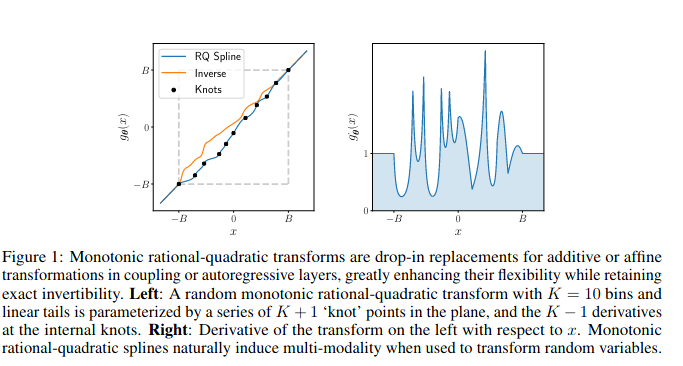

The rational quadratic function of the k-th bin is 

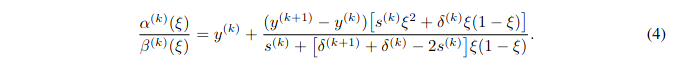

which has an analytical and efficient jacobian and inverse

The key is that the width and height of the bins are parameterized by a single layer fully connected neural network with a predefined number of hidden units. The network receives $x$ and returns a set of parameters related to the bins and derivatives of the knots

## NF in `pyro`

In what follows we will see how to learn the following bidimensional distribution using NF. We will start with a simple standard gaussian distribution

In [ ]:
X, Y = sklearn.datasets.make_moons(n_samples=1000, noise=0.1, random_state=1234)
X = (X - np.mean(X, axis=0))/np.std(X, axis=0)
X_tensor = torch.from_numpy(X.astype('float32'))

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.hist2d(X[:,0], X[:, 1], bins=20, cmap=plt.cm.Reds);

Transformations for distributions in `pyro` can be defined using the class [`TransformedDistribution`](https://pytorch.org/docs/master/distributions.html#torch.distributions.transformed_distribution.TransformedDistribution) as follows

```python
import pyro.distributions as dist
p2 = dists.TransformedDistribution(p1, [transformation_function])
```

where `transformation_function` is an object that inherits from the abstract class [`Transform`](https://pytorch.org/docs/master/distributions.html#torch.distributions.transforms.Transform). A transform $x=f_\theta(z)$ in `pyro` has to implement a forward $f_\theta(z)$, and inverse $f_\theta^{-1}(x)$ and the log absolute determinant  $\log | \text{det} \frac{\partial f_\theta}{\partial z}|$ functions.

By default the `Transform` class does not support learnable parameters. Transformations such as the planar or radial flows, that have learnable paramaters, are derived from [`TransformModule`](https://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.TransformModule) which in terms inherits from `torch.nn.Module`

Several transforms with and without learnable parameters can be found in `pyro.distributions.transforms` but not all of them have all the required methods implemented

For example `Planar` and `Radial` do not have the inverse method, as there is no analytical formula (closed-form expression) for the inverse. In what follows we test the multivariate Neural Spline flow which has a complete implementation, the transformation is exposed in [`dists.transforms.spline_coupling`](https://docs.pyro.ai/en/stable/distributions.html#spline-coupling)

The arguments of `spline_coupling` are 
- input_dim (int) – Dimension of input variable
- hidden_dims (list[int]): The desired hidden dimensions of the autoregressive network. Defaults to using [3*input_dim + 1]
- count_bins (int): The number of segments comprising the spline.
- bound (float): The bounding box, [−K,K]×[−K,K], of the spline.

In [ ]:
import pyro.distributions as dists
D = 2 # Number of dimensions
# Initial distribution
p1 = dists.Normal(torch.zeros(D), torch.ones(D))
# Transformation with learnable parameters
flow_transform = dists.transforms.spline_coupling(input_dim=D, hidden_dims=[7], count_bins=16)
# We register it as a pyro module
pyro.module("flow_transform", flow_transform)
# We create the transformed distribution
flow_dist = dists.TransformedDistribution(p1, [flow_transform])
# Create an optimizer for the parameters of the transformation
optimizer = torch.optim.Adam(flow_transform.parameters(), lr=1e-2)
# Maximize the marginal likelihood ala pytorch
for step in range(500):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(X_tensor).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

Finally, we can sample from `flow_dist` and inspect the results

In [ ]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.hist2d(X_flow[:,0], X_flow[:, 1], bins=20, cmap=plt.cm.Reds);

Manual implementation of a sequence of planar flow operators, not working!

Issues:

- https://github.com/pyro-ppl/pyro/issues/2718
- https://forum.pyro.ai/t/issue-with-optimizing-planar-flow-parameters-using-torch-optim/2096/5

In [ ]:
import pyro.distributions as dists
p1 = dists.Normal(torch.zeros(2), torch.ones(2))
K = 10
planar_list = []
for k in range(100):
    planar_list.append(dists.transforms.Radial(input_dim=2))
flow_transform = dists.ComposeTransformModule(planar_list)
pyro.module("my_transform", flow_transform)
flow_dist = dists.TransformedDistribution(p1, [flow_transform])
optimizer = torch.optim.Adam(flow_transform.parameters(), lr=1e-2)

for step in range(10):
    optimizer.zero_grad()
    #loss = -flow_dist.log_prob(X_tensor).mean()    
    prior_samples = p1.rsample(sample_shape=(1,))
    loss = -p1.log_prob(prior_samples).sum() #+ flow_transform.log_abs_det_jacobian(prior_samples, flow_transform(prior_samples)).sum()
    """
    for k in range(10):        
        prior_transformed = planar_list[k](prior_samples)
        loss -= planar_list[k].log_abs_det_jacobian(prior_samples, prior_transformed).sum()
        prior_samples = prior_transformed
    """
    loss.backward()
    optimizer.step()
    #flow_dist.clear_cache()
    #spline_transform.clear_cache()
    if step % 10 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

## Key idea: NF for more flexible posteriors in VI

The ELBO is tight when the approximate posterior $q(z|x)$ matches the true posterior $p(z|x)$. But this equivalence may not occur if we are restricted to very simple approximate posteriors. NF might give the approximate variational posterior enough flexibility to match the actual posterior. 

For example this can be used to add more flexible posteriors in VAE as shown in the following figure from [(Jimenez-Rezende and Mohamed, 2016)](https://arxiv.org/pdf/1505.05770.pdf) 

<img src="images/NF2.png" width="600">

The cost function in this case is

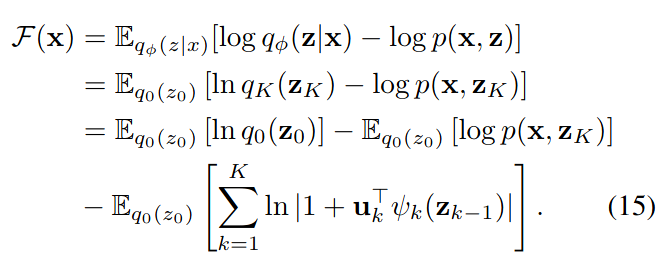

where the approximate posterior $q_\phi(z|x)$ is replaced by the flow distribution $q_K(z_K)$, a planar flow in this case.

and the algoritm to train the model

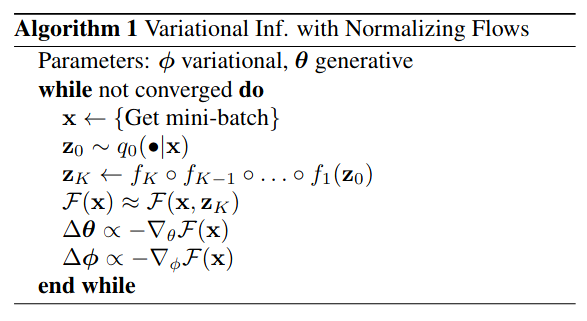

## Notes and other Resources

- A VAE-flow framework that generalize to abstract conditional flows is described in [(Su and Wu, 2018)](https://arxiv.org/pdf/1809.05861.pdf)
- In this lesson we didn't talk about big family of autorregresive flows, I recommend [(Huang et al 2018)](http://proceedings.mlr.press/v80/huang18d.html) to review recent advances
- Also we didn't talk about coupling which a general methodology to build non linear flows: https://arxiv.org/abs/1410.8516
- What we saw requires that we can write conditioned normalizing flows. This can be achieved using pyro's [`ConditionalTransformedDistribution`](https://docs.pyro.ai/en/stable/distributions.html#conditionaltransformeddistribution) 

Aside for the multiple citation here are some excellent resources used the write this lesson

- https://deepgenerativemodels.github.io/notes/flow/
- https://blog.evjang.com/2018/01/nf1.html
- https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html
- Tutorial by M. Brubaker in ECCV 2020 on NF for images:https://www.youtube.com/watch?v=u3vVyFVU_lI
- Awesome NF: https://github.com/janosh/awesome-normalizing-flows
- The pyro NF tutorial (only part 1 available): https://pyro.ai/examples/normalizing_flows_i.html
- Also this might be interesting in the future: https://flowtorch.ai/

